# Import

In [ ]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import plotly.graph_objects as go
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import openpyxl
from plotly.subplots import make_subplots
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from google.colab import files
from scipy import stats
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
import calendar
import plotly.figure_factory as ff
from scipy.stats import chi2_contingency 

In [ ]:
holidays_df = pd.read_csv('https://raw.githubusercontent.com/baryohay98/smp/main/Holidays2019_2021.csv', parse_dates=['Date'], index_col='Date') # טעינת קובץ חגים
smp_df = pd.read_csv('https://raw.githubusercontent.com/baryohay98/smp/main/SMP21__19.csv') # טעינת קובץ האסאמפי
temp_df = pd.read_csv('https://raw.githubusercontent.com/baryohay98/smp/main/Temp2019-2021.csv', parse_dates=['Date'], index_col='Date') # טעינת קובץ הטמפרטורות


# הוספת פיצ'רים לטבלה

In [ ]:
pivot_df = pd.pivot_table(data=temp_df, index=['Date','Hour']) # יצירת טבלת פיבוט כדי לקבל את הטמפרטורה הממוצעת בכל 10 דקות
pivot_df.tail(5)
df = pd.DataFrame(pivot_df.to_records()) # להחזיר את הפיבוט טייבל לדאטה פריים רגיל
df = df.loc[((df.Hour.str[3:] == '00') | (df.Hour.str[3:] == '30'))].reset_index(drop=True) # קבלת הטמפרטורה הממוצעת לפי חצאי שעות
df['SMP'] = smp_df.SMP_Value # הוספת עמודת האסאמפי לטבלת הטמפרטורות
df = df.astype({'Hour':'datetime64[ns]'}) # מפורמט של אובגקט לשעה
df['Hour'] = df['Hour'].apply(lambda x: x.strftime("%X")) # לקחת רק את השעה
df

,Date,Hour,Temp,SMP
0,2019-07-01,00:00:00,24.471429,146.47
1,2019-07-01,00:30:00,24.300000,171.22
2,2019-07-01,01:00:00,24.171429,128.82
3,2019-07-01,01:30:00,23.985714,149.85
4,2019-07-01,02:00:00,23.928571,146.53
...,...,...,...,...
30715,2021-03-31,21:30:00,12.257143,115.59
30716,2021-03-31,22:00:00,12.271429,115.59
30717,2021-03-31,22:30:00,12.057143,115.59
30718,2021-03-31,23:00:00,12.057143,103.20


In [ ]:
data = pd.merge(left=df, right=holidays_df, how='left',left_on='Date',right_on='Date')# הוספנו לטבלה את עמודת החגים
data['Is_Holiday'] = data['Desc'].apply(lambda x: 1 if not pd.isnull(x) else 0) # נירמלנו את עמודת החגים
data.drop('Desc', axis=1, inplace=True) 
data['Is_Vac'] = data['Date'].apply(lambda x: 1 if ((str(x) >= '2019-06-20' and str(x) < '2019-09-01') or (str(x) >= '2020-06-20' and str(x) < '2020-09-01')) else 0) # הוספת עמודה של חופש גדול
data['Is_Weekend'] = df['Date'].apply(lambda x: 1 if (x.weekday() == 4 or x.weekday() == 5) else 0) # הוספת עמודה של שישי או שבת
data['Temp'] = data['Temp'].round(2)
data

,Date,Hour,Temp,SMP,Is_Holiday,Is_Vac,Is_Weekend
0,2019-07-01,00:00:00,24.47,146.47,0,1,0
1,2019-07-01,00:30:00,24.30,171.22,0,1,0
2,2019-07-01,01:00:00,24.17,128.82,0,1,0
3,2019-07-01,01:30:00,23.99,149.85,0,1,0
4,2019-07-01,02:00:00,23.93,146.53,0,1,0
...,...,...,...,...,...,...,...
30715,2021-03-31,21:30:00,12.26,115.59,0,0,0
30716,2021-03-31,22:00:00,12.27,115.59,0,0,0
30717,2021-03-31,22:30:00,12.06,115.59,0,0,0
30718,2021-03-31,23:00:00,12.06,103.20,0,0,0


In [ ]:
cold_average = data[['Date','Hour','Temp']]
cold_average = df.groupby(cold_average['Date']).mean()
cold_average['Is_Cold'] = cold_average['Temp'].apply(lambda x: 1 if x <= 10 else 0) # הוספת עמודה של אם זה יום קר כלומר פחות מ10 מעלות
cold_average = cold_average[['Is_Cold']]
data = pd.merge(left=data, right=cold_average, how='left',left_on='Date',right_on='Date')
data

,Date,Hour,Temp,SMP,Is_Holiday,Is_Vac,Is_Weekend,Is_Cold
0,2019-07-01,00:00:00,24.47,146.47,0,1,0,0
1,2019-07-01,00:30:00,24.30,171.22,0,1,0,0
2,2019-07-01,01:00:00,24.17,128.82,0,1,0,0
3,2019-07-01,01:30:00,23.99,149.85,0,1,0,0
4,2019-07-01,02:00:00,23.93,146.53,0,1,0,0
...,...,...,...,...,...,...,...,...
30715,2021-03-31,21:30:00,12.26,115.59,0,0,0,0
30716,2021-03-31,22:00:00,12.27,115.59,0,0,0,0
30717,2021-03-31,22:30:00,12.06,115.59,0,0,0,0
30718,2021-03-31,23:00:00,12.06,103.20,0,0,0,0


In [ ]:
hot_average = data[['Date','Hour','Temp']]
hot_average = hot_average.drop(hot_average[((hot_average.Hour < "10:00:00") | (hot_average.Hour > "16:00:00"))].index) # להעיף את השעות של הלילה
hot_average = df.groupby(hot_average['Date']).mean()
hot_average.drop('SMP', axis=1, inplace=True) 
hot_average['Temp'] = np.int64(hot_average['Temp'])
hot_average
#hot_average.to_csv('DatesForHW.csv') # ייצוא לקובץ אקסל
#files.download('DatesForHW.csv') # הורדת קובץ האקסל

,Temp
Date,
2019-07-01,29
2019-07-02,28
2019-07-03,28
2019-07-04,29
2019-07-05,28
...,...
2021-03-27,14
2021-03-28,15
2021-03-29,16


In [ ]:
heat_waves_df = pd.read_csv('https://raw.githubusercontent.com/baryohay98/smp/main/HeatWave.csv', parse_dates=['Date'], index_col='Date') # ייבוא טבלאת השאילתה מהאסקיואל
heat_waves_df.drop(['Temp'], axis=1, inplace=True) # זריקת עמודות לא רלוונטיות
final_df = pd.merge(left=data, right=heat_waves_df, how='left',left_on='Date',right_on='Date')# חיבור עם הדאטה הרגיל שלנו
final_df['Is_HW'] = final_df['Is_HW'].apply(lambda x: 1 if not pd.isnull(x) else 0) # שינוי הנאלים ל0
final_df

,Date,Hour,Temp,SMP,Is_Holiday,Is_Vac,Is_Weekend,Is_Cold,Is_HW
0,2019-07-01,00:00:00,24.47,146.47,0,1,0,0,0
1,2019-07-01,00:30:00,24.30,171.22,0,1,0,0,0
2,2019-07-01,01:00:00,24.17,128.82,0,1,0,0,0
3,2019-07-01,01:30:00,23.99,149.85,0,1,0,0,0
4,2019-07-01,02:00:00,23.93,146.53,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...
30715,2021-03-31,21:30:00,12.26,115.59,0,0,0,0,0
30716,2021-03-31,22:00:00,12.27,115.59,0,0,0,0,0
30717,2021-03-31,22:30:00,12.06,115.59,0,0,0,0,0
30718,2021-03-31,23:00:00,12.06,103.20,0,0,0,0,0


In [ ]:
#דרך חלופית להוציא את גלי החום ללא סקיואל
#בדיקה האם גלי החום שחזרו משאילת הסקיואל באמת נכונים
mid_heatwave = hot_average.copy()
mid_heatwave['TempYesterday']=mid_heatwave.shift(periods=1, fill_value=0)
mid_heatwave['TempTommorow']=mid_heatwave.Temp.shift(periods=-1, fill_value=0)
mid_heatwave = mid_heatwave.loc[(mid_heatwave.Temp>=30) & (mid_heatwave.TempYesterday >= 30) & (mid_heatwave.TempTommorow >= 30)] #מביא את הימים שהם האמצע של גלי החום

start_heatwave = hot_average.copy()
start_heatwave['TempTommorow']=start_heatwave.shift(periods=-1, fill_value=0)#טממפרטורה ביום הבא
start_heatwave['TempNextTwoDays']=start_heatwave.Temp.shift(periods=-2, fill_value=0) # טמפרטורה בעוד 2 ימים
start_heatwave = start_heatwave.loc[(start_heatwave.Temp>=30) & (start_heatwave.TempTommorow >= 30) & (start_heatwave.TempNextTwoDays >= 30)] # מביא את הימים שם התחלה של גל חום

end_heatwave = hot_average.copy()
end_heatwave['TempYesterday']=end_heatwave.shift(periods=1, fill_value=0)#טמפרטורה יום קודם
end_heatwave['TempBeforeTwoDays']=end_heatwave.Temp.shift(periods=2, fill_value=0)#טמפרטורה לפני 2 ימים
end_heatwave = end_heatwave.loc[(end_heatwave.Temp>=30) & (end_heatwave.TempYesterday >= 30) & (end_heatwave.TempBeforeTwoDays >= 30)] # מביא את הימים האחרונים של גלי החום

mid_heatwave = mid_heatwave.drop(['TempYesterday','TempTommorow'],axis = 1)
start_heatwave = start_heatwave.drop(['TempTommorow','TempNextTwoDays'],axis = 1)
end_heatwave = end_heatwave.drop(['TempYesterday','TempBeforeTwoDays'], axis = 1)
concatHW = pd.concat([mid_heatwave,start_heatwave,end_heatwave])#חיבור כל התאריכים
concatHW = concatHW[~concatHW.index.duplicated(keep='first')]#הסרת כפילויות
concatHW

In [ ]:
final_df.describe().round(2)

,Temp,SMP,Is_Holiday,Is_Vac,Is_Weekend,Is_Cold,Is_HW
count,30720.00,30720.00,30720.0,30720.00,30720.00,30720.00,30720.00
mean,19.69,139.31,0.1,0.21,0.28,0.04,0.11
std,6.47,34.94,0.3,0.41,0.45,0.19,0.31
min,4.47,82.00,0.0,0.00,0.00,0.00,0.00
25%,14.04,115.81,0.0,0.00,0.00,0.00,0.00
50%,20.09,129.22,0.0,0.00,0.00,0.00,0.00
75%,24.77,159.90,0.0,0.00,1.00,0.00,0.00
max,37.43,1404.48,1.0,1.00,1.00,1.00,1.00


#מציאת אאוטליירים

In [ ]:
outliers_df = pd.DataFrame(data, columns=['Temp','SMP'])
outliers_df
c = ['hsl('+str(h)+',50%'+',50%)' for h in np.linspace(0, 360, len(outliers_df.columns)+1)]

i=0
fig = go.Figure()
fig = make_subplots(rows=1, cols=2)
fig.add_trace(
    go.Box( 
    y=outliers_df.iloc[:, i], 
    marker_color=c[i],
    name=outliers_df.columns[i]),row=1, col=1
   )
fig.update_yaxes(range=[0, outliers_df.Temp.max()+10],row=1, col=1)
i+=1

fig.add_trace(
    go.Box( 
    y=outliers_df.iloc[:, i], 
    marker_color=c[i],
    name=outliers_df.columns[i]),row=1, col=2
    )
fig.update_yaxes(range=[0, outliers_df.SMP.max()+60],row=1, col=2)


## הסרת ההאוטליירים הקיצוניים ביותר

In [ ]:
def get_outliers(df, series):
  q1 = series.quantile(0.25)
  q3 = series.quantile(0.75)

  if q1*q3 == 0:
    iqr = abs(2*(q1+q3))
    toprange = iqr
    botrange = -toprange
  else:
    iqr = q3-q1
    toprange = q3 + iqr * 1.5
    botrange = q1 - iqr * 1.5

  outliers_top=df[series > toprange*2] # מגדירים אאוטלייר 
  outliers_bot= df[series < botrange]
  outliers = pd.concat([outliers_bot, outliers_top], axis=0)

  return (botrange, toprange, outliers)
(botrange, toprange, outliers) = get_outliers(final_df, final_df.SMP)
final_df = final_df[~final_df.index.isin(outliers.index)] # מעיפים את ההאוטליירים מהטבלה
final_df.reset_index(inplace=True, drop=True) # שמים אינדקסים מחדש לעמודה בלי ההאוטליירים
final_df


,Date,Hour,Temp,SMP,Is_Holiday,Is_Vac,Is_Weekend,Is_Cold,Is_HW
0,2019-07-01,00:00:00,24.47,146.47,0,1,0,0,0
1,2019-07-01,00:30:00,24.30,171.22,0,1,0,0,0
2,2019-07-01,01:00:00,24.17,128.82,0,1,0,0,0
3,2019-07-01,01:30:00,23.99,149.85,0,1,0,0,0
4,2019-07-01,02:00:00,23.93,146.53,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...
30708,2021-03-31,21:30:00,12.26,115.59,0,0,0,0,0
30709,2021-03-31,22:00:00,12.27,115.59,0,0,0,0,0
30710,2021-03-31,22:30:00,12.06,115.59,0,0,0,0,0
30711,2021-03-31,23:00:00,12.06,103.20,0,0,0,0,0


## בדיקת אאוטליירים לאחר מחיקה

In [ ]:
outliers_df = pd.DataFrame(final_df, columns=['Temp','SMP'])
outliers_df
c = ['hsl('+str(h)+',50%'+',50%)' for h in np.linspace(0, 360, len(outliers_df.columns)+1)]

i=0
fig = go.Figure()
fig = make_subplots(rows=1, cols=2)
fig.add_trace(
    go.Box( 
    y=outliers_df.iloc[:, i], 
    marker_color=c[i],
    name=outliers_df.columns[i]),row=1, col=1
   )
fig.update_yaxes(range=[0, outliers_df.Temp.max()+10],row=1, col=1)
i+=1

fig.add_trace(
    go.Box( 
    y=outliers_df.iloc[:, i], 
    marker_color=c[i],
    name=outliers_df.columns[i]),row=1, col=2
    )
fig.update_yaxes(range=[0, outliers_df.SMP.max()+60],row=1, col=2)


In [ ]:
np.percentile(final_df.SMP, 89.85) # בדיקה באיזה אחוזון נמצא הערך 190

190.2566

In [ ]:
days = final_df.copy()
days.drop('Hour', axis=1, inplace=True)
days_pivot = pd.pivot_table(data=days, index=['Date']) # הכנת טבלה של הצגה לפי ימים
days = pd.DataFrame(days_pivot.to_records())

# מפת חום


In [ ]:
final_df.nunique() # בדיקה האם יש פיצרים עם שונות 0

Date           640
Hour            48
Temp          2442
SMP           7198
Is_Holiday       2
Is_Vac           2
Is_Weekend       2
Is_Cold          2
Is_HW            2
dtype: int64

In [ ]:
tbl = final_df[['Temp',	'SMP']]
corr_df = tbl.corr()
corr_df
fig = go.Figure(data=go.Heatmap(
                  z=tbl.corr(), 
                  x= corr_df.columns,  
                  y= corr_df.columns,))
fig.show()
# הצגת מפת חום של הקורלציה בין המשתנים
# SMP וטמפרטורה


# גרפים

##SMP התפלגויות של טמפרטורה ושל 

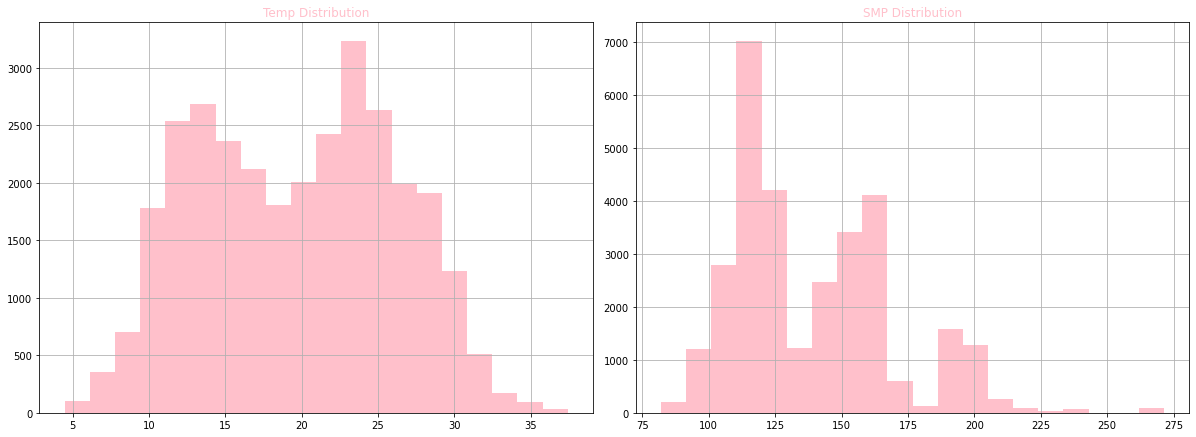

In [ ]:
def draw_histograms(dataframe, features, rows, cols):
    fig=plt.figure(figsize=(25,35))
    for i, feature in enumerate(features):
        ax=fig.add_subplot(rows,cols,i+1)
        dataframe[feature].hist(bins=20,ax=ax,facecolor='Pink')
        ax.set_title(feature+" Distribution",color='Pink')
        
    fig.tight_layout()  
    plt.show()
histo = final_df[['Temp','SMP']]
draw_histograms(histo,histo.columns,6,3)


## גרף המציג את התפלגות סוגי הימים 

In [ ]:
cold_days = days.Is_Cold.sum()
hot_days = days.Is_HW.sum()
hot_days
normaldays = len(days.index) - (hot_days+cold_days)
days_array = [cold_days,hot_days,normaldays]
fig = go.Figure()
fig.add_traces(go.Pie(labels=['Cold Days', 'Hot Days', 'Normal Days'], values=days_array))
fig.update_traces(hoverinfo='label+percent', textinfo='label+value', textfont_size=10, hole=0.4,
                  marker=dict(line=dict(color='#000000', width=1)))
fig.update_traces(pull=[0.3 if hot_days == i else 0 for i in days_array])
fig.show()


In [ ]:
days_per_year = days.copy()
days_per_year['Year'] = days_per_year['Date'].apply(lambda x: x.strftime("%Y")) # הוספת עמודה של שנה 
days_per_year['Month'] = days_per_year['Date'].dt.month # הוספת עמודה של חודש
days_2019 = days_per_year.loc[days_per_year['Year'] == '2019'] # הכנת טבלאות מחולקות לפי שנים
days_2020 = days_per_year.loc[days_per_year['Year'] == '2020']
days_2021 = days_per_year.loc[days_per_year['Year'] == '2021']
days_2020

,Date,Is_Cold,Is_HW,Is_Holiday,Is_Vac,Is_Weekend,SMP,Temp,Year,Month
184,2020-01-01,0,0,0,0,0,149.060833,11.137917,2020,1
185,2020-01-02,0,0,0,0,0,155.905833,10.961458,2020,1
186,2020-01-03,0,0,0,0,1,129.829167,10.628750,2020,1
187,2020-01-04,1,0,0,0,1,157.931250,9.075417,2020,1
188,2020-01-05,0,0,0,0,0,152.785000,10.696250,2020,1
...,...,...,...,...,...,...,...,...,...,...
545,2020-12-27,0,0,0,0,0,121.332083,13.185000,2020,12
546,2020-12-28,0,0,0,0,0,118.383125,12.014167,2020,12
547,2020-12-29,0,0,0,0,0,120.540833,13.155208,2020,12
548,2020-12-30,0,0,0,0,0,121.904792,14.288542,2020,12


In [ ]:
days_2019_month = df.groupby(days_2019['Month']).mean()
days_2019_month.reset_index(inplace = True)
days_2019_month['Month'] = days_2019_month['Month'].apply(lambda x: calendar.month_name[int(x)])

days_2020_jul_dec = days_2020.loc[days_2020['Date'] >= '2020-07-01'] # הכנת טבלה של שנת 2020 רק בחודשים החופפים לשנת 2019
days_2020_jul_dec_month = df.groupby(days_2020_jul_dec['Month']).mean() # גרופ ביי לפי חודשים
days_2020_jul_dec_month.reset_index(inplace = True)
days_2020_jul_dec_month['Month'] = days_2020_jul_dec_month['Month'].apply(lambda x: calendar.month_name[int(x)]) # הפיכת החודשים ממספר לשם החודש

days_2020_jan_mar = days_2020.loc[days_2020['Date'] < '2020-04-01']
days_2020_jan_mar_month = df.groupby(days_2020_jan_mar['Month']).mean() 
days_2020_jan_mar_month.reset_index(inplace = True)
days_2020_jan_mar_month['Month'] = days_2020_jan_mar_month['Month'].apply(lambda x: calendar.month_name[int(x)]) 


days_2020_month = df.groupby(days_2020['Month']).mean()
days_2020.reset_index(inplace = True)
days_2020['Month'] = days_2020['Month'].apply(lambda x: calendar.month_name[int(x)])

days_2021_month = df.groupby(days_2021['Month']).mean()
days_2021_month.reset_index(inplace = True)
days_2021['Month'] = days_2021['Month'].apply(lambda x: calendar.month_name[int(x)])

## גרף המראה את ממוצע האסאמפי בשנת 2019 אל מול שנת 2020 בכל חודש

In [ ]:
fig = go.Figure()
fig.add_trace(go.Bar(name='2019', x=days_2019_month.Month, y=days_2019_month.SMP, marker_color='palegreen'))
fig.add_trace(go.Bar(name='2020', x=days_2020_jul_dec_month.Month, y=days_2020_jul_dec_month.SMP, marker_color='lightskyblue'))
fig.update_layout(
    barmode='group',
    title='SMP 2019 Versus 2020', 
    yaxis_title='SMP Value')
fig.show()

## גרף המראה את האסאמפי לאורך כל השנים

In [ ]:
fig = go.Figure(data=go.Scatter(x=days.Date, y=days.SMP, mode='markers+lines')) 
fig.update_layout(
    title='SMP Each Day', 
    yaxis_title = 'Daily Total')
fig.update_yaxes(range=[0, days.SMP.max()+20])

fig.show()


## גרף המראה אסמפי ממוצע לכל יום בשבוע

In [ ]:
eachday = final_df.copy()
eachday['Day'] = eachday['Date'].apply(lambda x:1 if  x.weekday() == 6 else x.weekday()+2)
eachday = df.groupby(eachday['Day']).mean()
eachday.rename(index={1.0: 'Sunday',2.0:'Monday',3.0:'Tuesday',4.0:'Wednesday',5.0:'Thursday',6.0:'Friday',7.0:'Saturday'}, inplace=True)
fig = px.bar(eachday, y='SMP', x=eachday.index, color = eachday.index,
            title="Average SMP in each weekday")
fig.update_xaxes(title='Day')
fig.update_layout(showlegend=False)
fig.show()

# T test מזווגים

## חגים מול 11 ימים לפניהם

In [ ]:
holidays = final_df.loc[final_df['Is_Holiday'] == 1] # טבלה רק של החגים 
week_before_holidays_temp =  holidays.copy()
week_before_holidays_temp['Week_Before'] = week_before_holidays_temp['Date'].apply(lambda x: x - datetime.timedelta(days=11)) # הוצאת התאריכים של תקופת זמן לפני החגים
week_before_holidays_temp =week_before_holidays_temp['Week_Before']
week_before_holidays = final_df.loc[final_df.Date.isin(week_before_holidays_temp)]
week_before_check = week_before_holidays[week_before_holidays['Is_Holiday'] == 1] # בדיקה שאין חג גם באותה תקופה של לפני
week_before_check = week_before_check['Date']
holidays.drop(holidays.loc[holidays.Date.isin(week_before_check)].index, inplace=True) # הוצאת הימים שחשבנו שהם רגילים אבל הם חגים
week_before_holidays.drop(week_before_holidays.loc[week_before_holidays.Date.isin(week_before_check)].index, inplace=True)

a = week_before_holidays['SMP'].to_numpy()
b = holidays['SMP'].to_numpy()
stat, p = stats.ttest_rel(a, b)

print('stat=%.4f, p=%.4f' % (stat, p))
if p > 0.05:
	print('Probably same distribution')
else:
	print('Probably different distributions')
 
print('Holidays mean : ' +  str(b.mean()) + ' and median :  ' + str(holidays['SMP'].median()))
print('11 Days Before Holidays mean : ' +  str(a.mean()) + ' and median :  ' + str(week_before_holidays['SMP'].median()))



stat=5.3207, p=0.0000
Probably different distributions
Holidays mean : 138.78062836021508 and median :  127.89
11 Days Before Holidays mean : 141.99568548387097 and median :  138.78


In [ ]:
group_labels = ['11 Days Before Holidays', 'Holidays']

colors = ['#87CEFF','#EE82EE']


# Create distplot with curve_type set to 'normal'
fig = ff.create_distplot([a, b], group_labels, bin_size=2,
                         curve_type='kde', # override default 'kde'
                         colors=colors,show_rug=False)

# Add title
fig.update_layout(title_text='SMP Distribution in Holidays And 11 Days Before Holidays')
fig.update_yaxes(visible=False, showticklabels=False)
fig.show()

## ימי שישי ושבת מול ימי רביעי וחמישי


In [ ]:
weekends = final_df.loc[final_df['Is_Weekend'] == 1] # טבלה של ימי שישי ושבת
wed_thur =  weekends.copy()
wed_thur['days_before'] = wed_thur['Date'].apply(lambda x: x - datetime.timedelta(days=2)) # לקיחת התאריכים של ימי רביעי חמישי
wed_thur =wed_thur['days_before']
wed_thur_days = final_df.loc[final_df.Date.isin(wed_thur)]

a = weekends['SMP'].to_numpy()
b = wed_thur_days['SMP'].to_numpy()
stat, p = stats.ttest_rel(a, b)

print('stat=%.4f, p=%.4f' % (stat, p))
if p > 0.05:
	print('Probably same distribution')
else:
	print('Probably different distributions')
 
print('Weekends mean : ' +  str(a.mean()) + ' and median :  ' + str(weekends['SMP'].median()))
print('Wednesdays And Thursdays : ' +  str(b.mean()) + ' and median :  ' + str(wed_thur_days['SMP'].median()))


stat=-1.6274, p=0.1037
Probably same distribution
Weekends mean : 138.5980631868132 and median :  129.255
Wednesdays And Thursdays : 139.06734546703294 and median :  128.97


In [ ]:
group_labels = ['Weekends', 'Wednesdays And Thursdays']

colors = ['#8B7B8B', '#D8BFD8']


# Create distplot with curve_type set to 'normal'
fig = ff.create_distplot([a, b], group_labels, bin_size=2,
                         curve_type='kde', # override default 'kde'
                         colors=colors,show_rug=False)

# Add title
fig.update_layout(title_text='SMP Distribution in weekends versus wednesdays and thursdays')
fig.update_yaxes(visible=False, showticklabels=False)
fig.show()

## גל חום ושבוע לפניו בשנת 2020

In [ ]:
heatwaves20 = days_2020.loc[days_2020['Is_HW'] == 1] # טבלה גלי חום ב2020
week_before = heatwaves20.copy()
week_before['Week_Before'] = week_before['Date'].apply(lambda x: x - datetime.timedelta(days=7))
week_before1 =week_before['Week_Before']
week_before_checker = heatwaves20[heatwaves20.Date.isin(week_before1)]
week_before_checker = week_before_checker['Date']
heatwaves20.drop(heatwaves20.loc[heatwaves20.Date.isin(week_before_checker)].index,inplace = True)
week_before.drop(week_before.loc[week_before.Week_Before.isin(week_before_checker)].index,inplace = True)
heatwaves20 = heatwaves20['Date']
week_before = week_before['Week_Before']
heatwaves20full = final_df[final_df.Date.isin(heatwaves20)]
week_before_date = final_df[final_df.Date.isin(week_before)]

a = heatwaves20full['SMP'].to_numpy()
b = week_before_date['SMP'].to_numpy()
stat, p = stats.ttest_rel(a, b)

print('stat=%.4f, p=%.4f' % (stat, p))
if p > 0.05:
	print('Probably same distribution')
else:
	print('Probably different distributions')
print(a.mean())
print(b.mean())


print('Heatwaves in 2020 mean : ' +  str(a.mean()) + ' and median :  ' + str(heatwaves20full['SMP'].median()))
print('A Week before heatwaves in 2020 : ' +  str(b.mean()) + ' and median :  ' + str(week_before_date['SMP'].median()))

stat=22.9407, p=0.0000
Probably different distributions
152.06314102564102
130.85460737179486
Heatwaves in 2020 mean : 152.06314102564102 and median :  160.0
A Week before heatwaves in 2020 : 130.85460737179486 and median :  119.02


In [ ]:
group_labels = ['Heatwaves in 2020', 'A week before heatwaves in 2020']

colors = ['red','#BCD2EE']



# Create distplot with curve_type set to 'normal'
fig = ff.create_distplot([a, b], group_labels, bin_size=2,
                         curve_type='kde', # override default 'kde'
                         colors=colors,show_rug=False)

# Add title
fig.update_layout(title_text='SMP Distribution in heatwaves versus 7 Days before heatwaves in 2020')
fig.update_yaxes(visible=False, showticklabels=False)
fig.show()

## ימים של גל קור מול אותם ימים בלי גל קור בשנה 2020 ו2021

In [ ]:
cold20 = days_2020.loc[days_2020['Is_Cold'] == 1]
same_days_2021 = cold20.copy()
same_days_2021['days_after'] = same_days_2021['Date'].apply(lambda x: x + datetime.timedelta(days=366))
same_days_year_2021_list = same_days_2021['days_after']
cold21 = days_2021.loc[days_2021.Date.isin(same_days_year_2021_list)]
duplicate_cold21 = cold21.loc[cold21['Is_Cold']==1]
duplicate_cold21 = duplicate_cold21['Date']
duplicate20 = same_days_2021.loc[same_days_2021.days_after.isin(duplicate_cold21)]
duplicate20 = duplicate20['Date']
cold21.drop(cold21.loc[cold21.Date.isin(duplicate_cold21)].index,inplace = True) 
cold20.drop(cold20.loc[cold20.Date.isin(duplicate20)].index,inplace = True)

a = cold20['SMP'].to_numpy()
b = cold21['SMP'].to_numpy()
stat, p = stats.ttest_rel(a, b)

print('stat=%.4f, p=%.4f' % (stat, p))
if p > 0.05:
	print('Probably same distribution')
else:
	print('Probably different distributions')

print('Cold Days in 2020 mean : ' +  str(a.mean()) + ' and median :  ' + str(cold20['SMP'].median()))
print('Cold Days in 2021 : ' +  str(b.mean()) + ' and median :  ' + str(cold21['SMP'].median()))

stat=15.3296, p=0.0000
Probably different distributions
Cold Days in 2020 mean : 158.3370535714286 and median :  158.84447916666667
Cold Days in 2021 : 115.45763392857143 and median :  115.91489583333333


In [ ]:
group_labels = ['Cold Days In 2020', 'Cold Days In 2021']

colors = ['#20B2AA', '#87CEFA']

# Create distplot with curve_type set to 'normal'
fig = ff.create_distplot([a, b], group_labels, bin_size=2,
                         curve_type='kde', # override default 'kde'
                         colors=colors,show_rug=False)

# Add title
fig.update_layout(title_text='SMP Distribution in cold days in at 2020 versus 2021')
fig.update_yaxes(visible=False, showticklabels=False)
fig.show()

## חודש לפני החופש הגדול וחודש מהחופש הגדול בשנת 2020

In [ ]:
before_vac = final_df.loc[(final_df['Date'] >= '2020-05-20') & (final_df['Date'] < '2020-06-20')]
vacation_20 = final_df.loc[(final_df['Date'] >= '2020-06-20') & (final_df['Date'] < '2020-07-21')]

a = before_vac['SMP'].to_numpy()
b = vacation_20['SMP'].to_numpy()
stat, p = stats.ttest_rel(a, b)

print('stat=%.4f, p=%.4f' % (stat, p))
if p > 0.05:
	print('Probably same distribution')
else:
	print('Probably different distributions')

print('30 Days before summer vacation : ' +  str(a.mean()) + ' and median :  ' + str(before_vac['SMP'].median()))
print('30 Days of summer vacation : ' +  str(b.mean()) + ' and median :  ' + str(vacation_20['SMP'].median()))

stat=2.2153, p=0.0269
Probably different distributions
30 Days before summer vacation : 126.69137768817205 and median :  119.16
30 Days of summer vacation : 125.11908602150538 and median :  120.195


In [ ]:
group_labels = ['30 Days before summer vacation', '30 Days of summer vacation']

colors = ['deeppink', 'lightsteelblue']


# Create distplot with curve_type set to 'normal'
fig = ff.create_distplot([a, b], group_labels, bin_size=2,
                         curve_type='kde', # override default 'kde'
                         colors=colors,show_rug=False)

# Add title
fig.update_layout(title_text='SMP Distribution in 30 days of summer vacation versus 30 days earlier in 2020')
fig.update_yaxes(visible=False, showticklabels=False)
fig.show()

## בדיקה האם התפלגות האסאמפי של 2019 ו2020 דומה או שונה  


In [ ]:
a = days_2019['SMP'].to_numpy()
b = days_2020_jul_dec['SMP'].to_numpy()
stat, p = stats.ttest_rel(a, b)

print('stat=%.4f, p=%.4f' % (stat, p))
if p > 0.05:
	print('Probably same distribution')
else:
	print('Probably different distributions')
 

print('SMP in 2019 : ' +  str(a.mean()) + ' and median :  ' + str(days_2019['SMP'].median()))
print('SMP in 2020 : ' +  str(b.mean()) + ' and median :  ' + str(days_2020_jul_dec['SMP'].median()))

stat=28.2544, p=0.0000
Probably different distributions
SMP in 2019 : 160.0416619558355 and median :  159.2965625
SMP in 2020 : 132.10340579710143 and median :  131.48208333333332


In [ ]:


group_labels = ['2020', '2019']

colors = ['#63F5EF', '#835AF1']

# Create distplot with curve_type set to 'normal'
fig = ff.create_distplot([a, b], group_labels, bin_size=2,
                         curve_type='kde', # override default 'kde'
                         colors=colors,show_rug=False)

# Add title
fig.update_layout(title_text='SMP Distribution in 2019 and 2020')
fig.update_yaxes(visible=False, showticklabels=False)
fig.show()


## התפלגות אסאמפי 2020 מול 2021

In [ ]:
days_2020_without_29 = days_2020_jan_mar.drop(days_2020_jan_mar.loc[days_2020_jan_mar['Date'] == '2020-02-29'].index) # הסרת ה29 בפרואר בגלל שנה מעוברת
a = days_2021['SMP'].to_numpy()
b = days_2020_without_29['SMP'].to_numpy()

stat, p = stats.ttest_rel(a, b)

print('stat=%.4f, p=%.4f' % (stat, p))
if p > 0.05:
	print('Probably same distribution')
else:
	print('Probably different distributions')

print('SMP in 2021 : ' +  str(a.mean()) + ' and median :  ' + str(days_2021['SMP'].median()))
print('SMP in 2020 : ' +  str(b.mean()) + ' and median :  ' + str(days_2020_without_29['SMP'].median()))

stat=-22.0554, p=0.0000
Probably different distributions
SMP in 2021 : 116.48258796296297 and median :  116.85333333333332
SMP in 2020 : 146.3253125 and median :  149.40489583333334


In [ ]:


group_labels = ['2020', '2021']

colors = ['#2BCDC1', '#F66095']

# Create distplot with curve_type set to 'normal'
fig = ff.create_distplot([a, b], group_labels, bin_size=2,
                         curve_type='kde', # override default 'kde'
                         colors=colors,show_rug=False)

# Add title
fig.update_layout(title_text='SMP Normal Distribution in 2020 and 2021')
fig.update_yaxes(visible=False, showticklabels=False)
fig.show()

#מבחני טי לא מזווגים

## שעון חורף מול שעון קיץ

In [ ]:
summer_clock_dates = final_df.loc[(final_df['Date'] < '2019-10-28') | ((final_df['Date'] >= '2020-03-27') & (final_df['Date'] < '2020-10-25'))]
summer_clock_dates_index = summer_clock_dates['Date']
winter_clock_dates = final_df.loc[~final_df.Date.isin(summer_clock_dates_index)]

a =summer_clock_dates.SMP
b = winter_clock_dates.SMP

t_stat, p = stats.ttest_ind(a, b)
print(f't={t_stat}, p={p}')



t=35.625810564177705, p=1.9881298516668e-272


## ימים קרים מול ימים חמים

In [ ]:
hot = final_df.loc[final_df['Is_HW'] == 1]
cold = final_df.loc[final_df['Is_Cold'] == 1]

a =hot.SMP
b = cold.SMP
t_stat, p = stats.ttest_ind(a, b)
print(f't={t_stat}, p={p}')

t=6.572318330819126, p=5.515943485211502e-11


## ימים בגל חום מול שאר הימים

In [ ]:
heatwaves = final_df.loc[final_df['Is_HW'] == 1]
notheatwaves = final_df.loc[final_df['Is_HW'] == 0]

a = heatwaves.SMP
b = notheatwaves.SMP
t_stat, p = stats.ttest_ind(a, b)
print(f't={t_stat}, p={p}')

t=33.82475427196447, p=2.850955448194036e-246


## ימים רגילים מול ימים קרים

In [ ]:
coldays = final_df.loc[final_df['Is_Cold'] == 1]
notcoldays = final_df.loc[final_df['Is_Cold'] == 0]

a = coldays.SMP
b = notcoldays.SMP
t_stat, p = stats.ttest_ind(a, b)
print(f't={t_stat}, p={p}')


t=11.424573856882727, p=3.62708554373831e-30


## סופ"ש מול שאר השבוע

In [ ]:
weeknds = final_df.loc[final_df['Is_Weekend'] == 1]
notweeknds = final_df.loc[final_df['Is_Weekend'] == 0]

a = weeknds.SMP
b = notweeknds.SMP

t_stat, p = stats.ttest_ind(a, b)
print(f't={t_stat}, p={p}')


t=-1.645422665676626, p=0.09989291210925426


## חגים מול ימי חול

In [ ]:
isholiday = final_df.loc[final_df['Is_Holiday'] == 1]
notisholiday = final_df.loc[final_df['Is_Holiday'] == 0]

a = isholiday.SMP
b = notisholiday.SMP

t_stat, p = stats.ttest_ind(a, b)
print(f't={t_stat}, p={p}')


t=1.6336160165585707, p=0.10234975312994408


## חופש גדול מול ימים רגילים ללא חופש

In [ ]:
summervac = final_df.loc[final_df['Is_Vac'] == 1]
notsummervac = final_df.loc[final_df['Is_Vac'] == 0]

a = summervac.SMP
b = notsummervac.SMP

t_stat, p = stats.ttest_ind(a, b)
print(f't={t_stat}, p={p}')


t=28.972482109475393, p=4.143707390210811e-182


#מבחן חי בריבוע 


## בדיקת קשר בין גלי חום לאסמפי גבוהה מ - 190 

In [ ]:
is_above_190 = final_df.copy()
is_above_190['SMP_Above_190'] = final_df['SMP'].apply(lambda x: 1 if x >= 190 else 0)

chisqt = pd.crosstab(is_above_190.SMP_Above_190, is_above_190.Is_HW, margins=True)
print(chisqt)
value = np.array([chisqt.iloc[0][0:5].values,
                  chisqt.iloc[1][0:5].values])
result = chi2_contingency(value)[0:3]
p = result[1]
print("\np value: " + str(p)) 
if p <= 0.05: 
    print('\nReject NULL HYPOTHESIS') 
else: 
    print('\nACCEPT NULL HYPOTHESIS') 

Is_HW              0     1    All
SMP_Above_190                    
0              24935  2653  27588
1               2466   659   3125
All            27401  3312  30713

p value: 4.226985064826456e-84

Reject NULL HYPOTHESIS
